In [1]:
using Rays

# A view of a cube

### The basic setup

In [2]:
# Define the scene
scene = Rays.Scene()

# Define a camera
camera = Rays.Camera(; screen_res = [500, 500])
push!(scene, camera)

# Define a cube at the origin
cube = Rays.Cube(zeros(Float32, 3), 1.0f0)
push!(scene, cube)

# Show scene information
display(scene)

# Let the camera look towards the origin
from = Float32[2.0, 2.0, 2.0]
to = zeros(Float32, 3)
Rays.look_at!(camera, from, to)

# Set how shape brightness drops of with distance to the camera
# in a default way based on the shapes in the scene relative to the camera.
camera = Rays.set_dropoff_curve_default!(scene, camera)

# Compute ray intersections with the cube
Rays.render!(scene)

Rays.Scene{Float32}
* Cameras:
	<Camera 'camera'>

* Shapes:
	<Cube 'cube'>


### Viewing the canvas

In [3]:
using Images: colorview, RGB, N0f8

function view_canvas(camera)
    canvas_RGB = RGB{N0f8}.([view(camera.canvas, channel, :, :) for channel = 1:3]...)
    colorview(RGB, canvas_RGB)
end

view_canvas (generic function with 1 method)

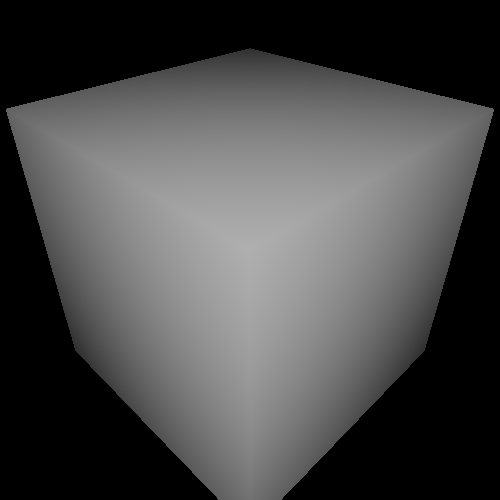

In [4]:
view_canvas(camera)

### Adding color

In [5]:
# Assign the Julia colors the different intersection dimensions
julia_green = Float32[0.22, 0.596, 0.149]
julia_purple = Float32[0.584, 0.345, 0.698]
julia_red = Float32[0.796, 0.235, 0.2]
julia_colors = hcat(julia_green, julia_purple, julia_red)

Rays.render!(scene, color_palette = julia_colors, variable = :dim)

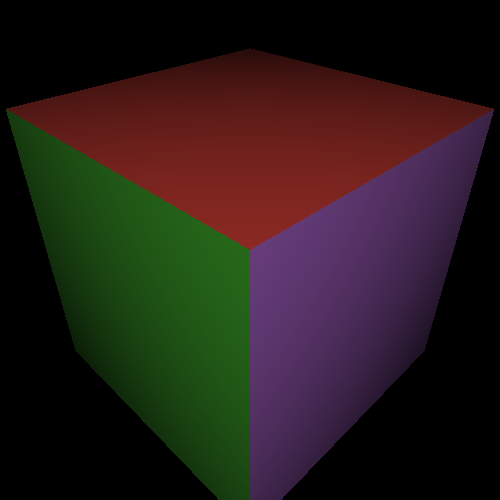

In [6]:
view_canvas(camera)

### Adding depth of field

In [7]:
# This curve determines how the blurring depends on the distance to
# the camera
focus_curve(t) = 0.5 + 10 * abs(t - 3)
camera = @set camera.focus_cure = focus_curve
push!(scene, camera; replace = true)

# Add depth of field
Rays.add_depth_of_field!(camera, focus_curve);

ErrorException: type Camera has no field canvas_color

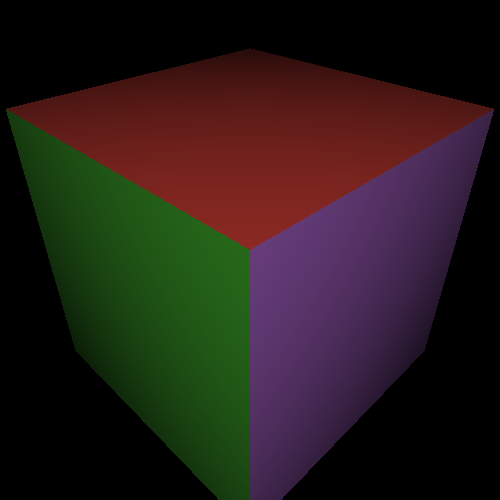

In [7]:
view_canvas(camera)

### Replace the cube by a Menger sponge

In [8]:
# Get ray intersections while collecting the data of the intersection dimension
menger_sponge = Rays.menger_sponge(zeros(Float32, 3), 1.0, 4)
delete!(scene.shapes, :cube)
push!(scene, menger_sponge)
Rays.shape_view!(scene)

# Generate an image from the ray intersections
# The brightness drops off with the distance to the camera
Rays.cam_is_source!(camera)

# Assign the Julia colors to the different intersection dimensions
Rays.get_color!(camera, :dim, julia_colors)

# Apply color to the image
Rays.apply_color!(camera)

# Add depth of field
Rays.add_depth_of_field!(camera, focus_curve);

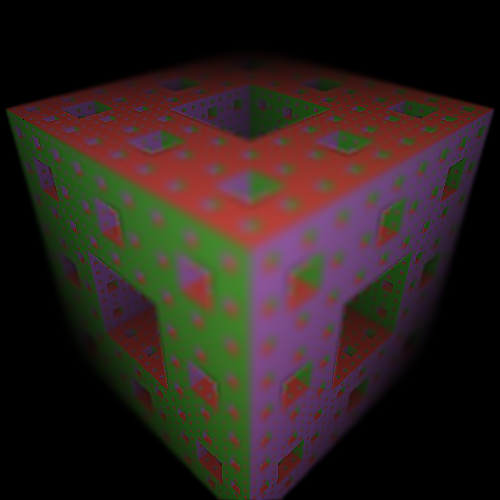

In [9]:
canvas_RGB = RGB{N0f8}.([view(camera.canvas_color, channel, :, :) for channel = 1:3]...)
colorview(RGB, canvas_RGB)

### Add a camera warp

In [10]:
# Define warp function and assign it to the camera
function warp!(v)::Nothing
    v[3] = v[3] + 0.1 * sin(250 * v[2])
    v[1] = v[1] + 0.1 * sin(250 * v[2])
    return nothing
end

camera_args = [getfield(camera, f) for f in fieldnames(Rays.Camera)]
camera_args[12] = warp!
camera_args[1] = [:camera_warped]
camera_warped = Rays.Camera(camera_args...)
Rays.add_intersection_data_variables!(camera, [:dim])
delete!(scene.cameras, :camera)
push!(scene, camera_warped)

# Get ray intersections while collecting the data of the intersection dimension
Rays.shape_view!(scene)

# Generate an image from the ray intersections
# The brightness drops off with the distance to the camera
Rays.cam_is_source!(camera)

# Assign the Julia colors to the different intersection dimensions
Rays.get_color!(camera, :dim, julia_colors)

# Apply color to the image
Rays.apply_color!(camera)

# Add depth of field
Rays.add_depth_of_field!(camera, focus_curve);

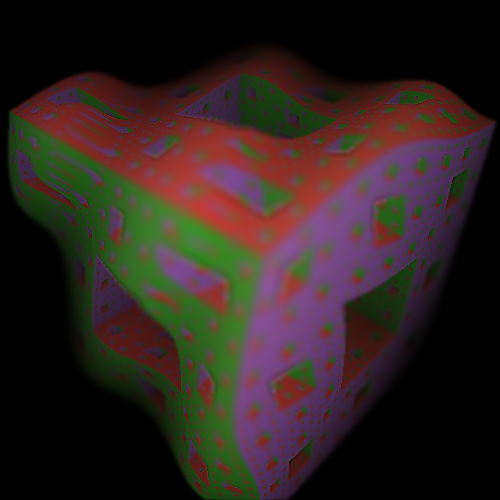

In [11]:
canvas_RGB = RGB{N0f8}.([view(camera.canvas_color, channel, :, :) for channel = 1:3]...)
colorview(RGB, canvas_RGB)

# Available shapes

### Default

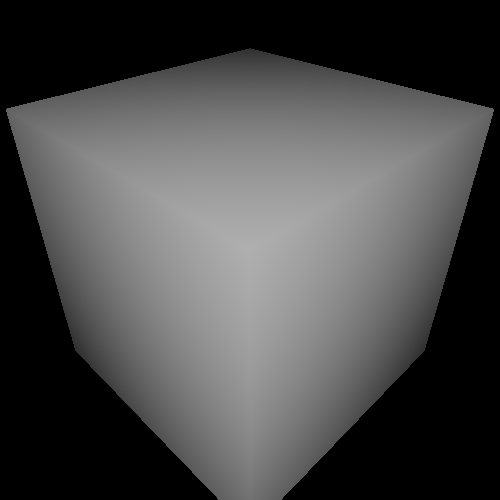

<Cube 'cube'>


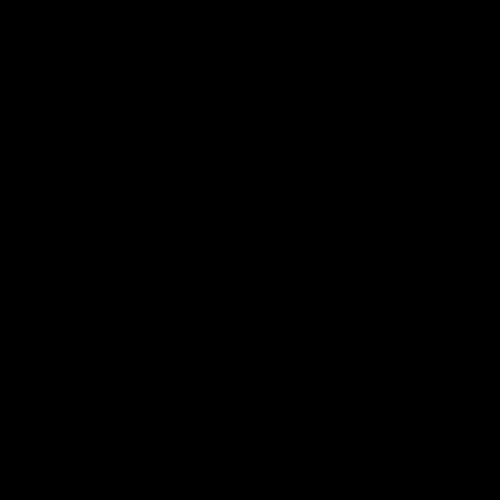

<FractalShape 'menger_sponge'; 20 subshapes of type Rays.Cube{Float32}>


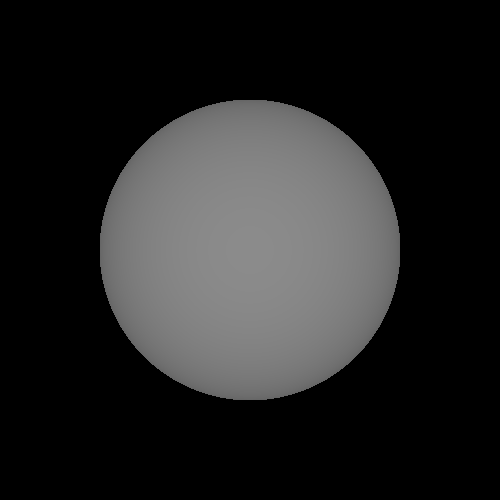

<Sphere 'sphere'>

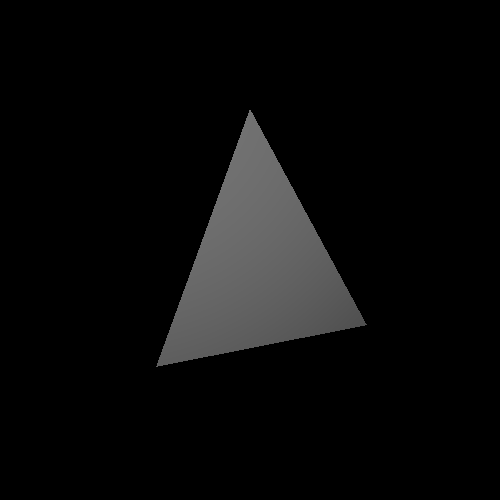

<TriangleShape 'tetrahedron'; with 4 vertices and 4 faces>

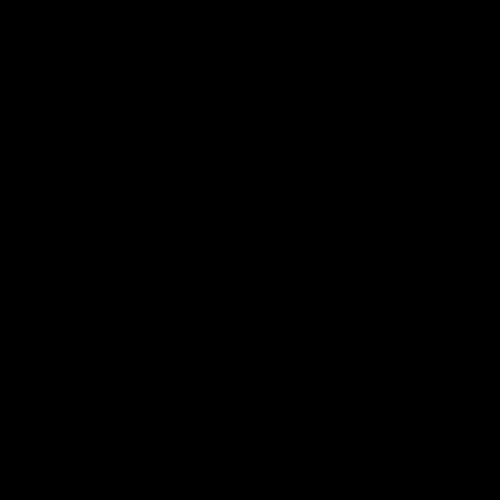

<FractalShape 'sierpinski_pyramid'; 4 subshapes of type Rays.TriangleShape{Float32}>


In [7]:
origin = zeros(Float32, 3)
R = 1.0f0

# delete!(scene.cameras, :camera_warped)
# push!(scene, camera)

shapes = [
    Rays.Cube(origin, R),
    Rays.menger_sponge(origin, R, 4),
    Rays.Sphere(origin, R),
    Rays.Tetrahedron(origin, R),
    Rays.sierpinski_pyramid(origin, R, 4)
]

function simple_view(shape)
    delete!(scene.shapes, only(keys(scene.shapes)))
    push!(scene, shape)
    Rays.render!(scene)
    println(shape)
    display(view_canvas(camera))
end

for shape in shapes
    simple_view(shape)
end
    

### Custom

Implicit surface

In [ ]:
"""
The 0-set of this function is an equipotential surface for 4 point sources.
"""
function my_field(loc::Vector{F})::F where {F}
	x, y, z = loc
	out = -4.0f0
	for i in 0:3
		θ = convert(F, π * (i / 2 + 0.33))
		out += one(F) / sqrt((x - cos(θ))^2 + (y - sin(θ))^2 + z^2)
	end
	return out
end

In [ ]:
equipotential_surface =
	Rays.ImplicitSurface(
		my_field, 
		zeros(Float32, 3); 
		R_bound = 1.5f0, 
		n_divisions = 50, 
		tol = 1.0f-5, 
		itermax = 10,
		name = :equipotential_surface)

simple_view(equipotential_surface)

Triangle mesh

In [8]:
"""
Approximate a donut shape
"""
function Donut(R::F, r::F, n_θ::I, n_ϕ::I)::Rays.TriangleShape where {F <: AbstractFloat, I <: Integer}
    n_vertices = n_θ * n_ϕ
    n_faces = 2 * n_vertices

    Θ = range(0, 2π, n_θ + 1)[1:end-1]
    Φ = range(0, 2π, n_ϕ + 1)[1:end-1]

    vertices = zeros(F, n_vertices, 3)
    faces = zeros(I, 2 * n_θ * n_ϕ, 3)

    for (i, θ) in enumerate(Θ)
        for (j, ϕ) in enumerate(Φ) 

            vertex_idx_1 = (i - 1) * n_ϕ + j
            vertex_idx_2 = (i % n_θ) * n_ϕ + j
            vertex_idx_3 = (i - 1) * n_ϕ + j % n_ϕ + 1
            vertex_idx_4 = (i % n_θ) * n_ϕ + j % n_ϕ + 1

            vertices[vertex_idx_1, :] = [
                cos(θ) * (R + r*cos(ϕ)),
                sin(θ) * (R + r*cos(ϕ)),
                r * sin(ϕ)
            ]

            faces[vertex_idx_1, :] = [
                vertex_idx_1, 
                vertex_idx_2,
                vertex_idx_3,
            ]

            faces[n_vertices + vertex_idx_1, :] = [
                vertex_idx_4, 
                vertex_idx_2,
                vertex_idx_3,
            ]
        end
    end

    origin = zeros(F, 3)

    return Rays.TriangleShape(
        vertices, 
        faces, 
        origin, 
    )
end

Donut

In [9]:
# Adjust camera
cam_donut = Rays.Camera(; screen_res = [400, 500], name = :cam_donut)
cam_donut.screen_size .= [0.08, 0.1]
Rays.look_at!(cam_donut, from, to)
push!(scene, cam_donut)

# Define donut shape
donut = Donut(1.0f0, 0.3f0, 50, 25)
delete!(scene.shapes, only(keys(scene.shapes)))
push!(scene, donut)

# Set how shape brightness drops of with distance to the camera
# in a default way based on the shapes in the scene relative to the camera.
cam_donut = Rays.set_dropoff_curve_default!(scene, cam_donut)

# Generate a random color per face
face_colors = (1.0 .+ rand(3, donut.n_faces))/2
face_colors = convert(Matrix{Float32}, face_colors)

Rays.render!(scene, color_palette = face_colors, variable = :face)

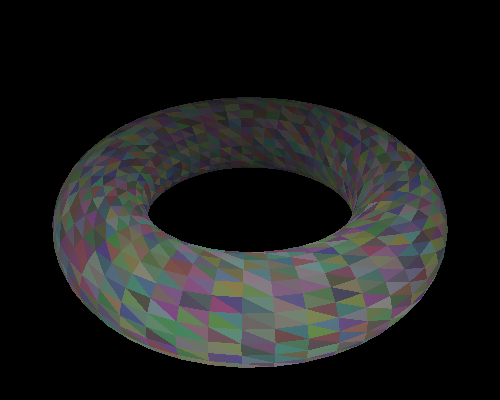

In [10]:
view_canvas(cam_donut)